In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# reading docfiles
import docx2txt

#nltk
import nltk
from nltk.tokenize import word_tokenize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
word_exclusions = pd.read_excel("input/word_exclusions.xlsx")

word_exclusions = word_exclusions[word_exclusions["exclude"] == 1]

word_exclusions = word_exclusions.drop(columns=['exclude', 'exclude_short_list'], axis = 1)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(word_exclusions["word"])
stop_words.extend(["gut"])

In [4]:
df = pd.read_excel("input/app_v1/app_v1_feedback.xlsx")

In [5]:
df.head()

,transcript_id,person_id,segment_id,context,lesson,text,category_id
0,ss_01,p_01,s_001,NaN,NaN,Das ist in Ordnung.,1
1,ss_01,p_01,s_002,NaN,NaN,"Eine kurze Zwischenfrage, wann soll die App ei...",1
2,ss_01,p_01,s_003,In der ersten Version läuft die jetzt schon se...,NaN,Interessant. Okay.,1
3,ss_01,p_01,s_004,"Ich würde einfach anfangen, ein bisschen allge...",NaN,"Nein, soweit nicht. Alles klar.",1
4,ss_01,p_01,s_005,"Perfekt, klasse. Ist das Ihre erste Schwangers...",NaN,Ja.,12


In [6]:
strengths = df[df["category_id"] == 9]

In [7]:
strengths = strengths.drop(columns=['transcript_id', 'person_id', 'segment_id', 'context', 'lesson', 'category_id'], 
             axis = 1)

In [8]:
strengths['text_processed'] = \
strengths['text'].map(lambda x: re.sub('[,.!?]', '', x))

In [9]:
strengths['text_processed'] = \
strengths['text_processed'].map(lambda x: x.lower())

In [10]:
feedback = strengths['text_processed']

feedback_token = feedback.apply(word_tokenize)
feedback_token.head()

74    [inhaltlicher, natur, waren, mir, viele, kommu...
75    [das, macht, einem, das, immer, noch, einmal, ...
76    [ich, hatte, mir, jetzt, auch, noch, einmal, a...
78    [genau, dann, noch, eine, kleinigkeit, :, nach...
83    [nein, fand, ich, nicht, der, hintergrund, ist...
Name: text_processed, dtype: object

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc = True))

In [12]:
data = strengths.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['inhaltlicher', 'natur', 'waren', 'mir', 'viele', 'schon', 'vor', 'dem', 'studium', 'bekannt', 'aber', 'ich', 'fand', 'es', 'gut', 'dass', 'ich', 'das', 'jetzt', 'noch_einmal', 'wiederholen', 'und', 'auffrischen', 'konnte']


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(feedback_token)

In [16]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [17]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("de_core_news_sm", disable = ['parser', 'ner'])

In [18]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['inhaltlich', 'Natur', 'Studium', 'bekannt', 'finden', 'wiederholen', 'auffrischen']]


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [20]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('Natur', 1),
  ('Studium', 1),
  ('auffrischen', 1),
  ('bekannt', 1),
  ('finden', 1),
  ('inhaltlich', 1),
  ('wiederholen', 1)]]

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"finden" + 0.027*"mögen" + 0.022*"lernen" + 0.017*"Kommunikation" + '
  '0.017*"Thema" + 0.017*"Geburt" + 0.012*"kurz" + 0.012*"einfach" + '
  '0.012*"bissch" + 0.012*"ganz"'),
 (1,
  '0.041*"finden" + 0.024*"mögen" + 0.015*"Idee" + 0.015*"Lektion" + '
  '0.015*"glauben" + 0.015*"immer" + 0.010*"Beispiel" + 0.010*"neutral" + '
  '0.010*"Aufforderung" + 0.010*"fällen"'),
 (2,
  '0.020*"Frage" + 0.015*"Lektion" + 0.015*"persönlich" + 0.015*"geben" + '
  '0.011*"finden" + 0.011*"kommen" + 0.011*"total" + 0.011*"Alltag" + '
  '0.011*"nächster" + 0.011*"sagen"')]


In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.890992828755799

Coherence Score:  0.4525040396990481


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.031881 -0.076899       1        1  36.378325
2     -0.105245  0.017861       2        1  34.369296
0      0.073365  0.059038       3        1  29.252379, topic_info=            Term       Freq      Total Category  logprob  loglift
209        mögen   6.000000   6.000000  Default  30.0000  30.0000
4         finden  10.000000  10.000000  Default  29.0000  29.0000
109        geben   2.000000   2.000000  Default  28.0000  28.0000
7         Geburt   2.000000   2.000000  Default  27.0000  27.0000
15       glauben   2.000000   2.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
16         immer   0.770399   3.626268   Topic3  -4.9875  -0.3198
132        Frage   0.760937   4.209986   Topic3  -4.9998  -0.4815
2    auffrischen   0.755090   1.781553   Topic3  -5.0075   0.3708
51      nächster   0.754658   2.376564   Topic3  -5.0081   0.0821
146      Ansicht   0.754224   1.781636   Topic3  -5.0087   0.3696

[172 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
41        2  0.830259   Abschlussfrag
103       2  0.551996          Alltag
130       3  0.860379       Anleitung
146       1  0.561282         Ansicht
146       3  0.561282         Ansicht
...     ...       ...             ...
246       1  0.821887        wünschen
227       2  0.830264   zurückzuschau
154       3  0.860405  zwischenfragen
155       3  0.860405          ändern
144       3  0.860384       überlegen

[161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [88]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [92]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=1, 
                                                        limit=30, 
                                                        step=1)

In [93]:
os.chdir("C:\\Users\\vanandkuma\\Documents\\projects\\sentiment_analysis")

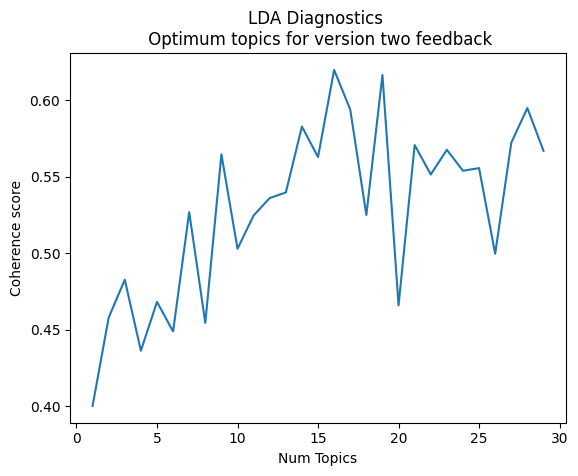

In [95]:
# Show graph
limit=30; start=1; step=1;
x = range(start, limit, step)
plt.title("LDA Diagnostics \n Optimum topics for version two feedback")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.savefig('output/app_v1_lda_topic_coherence.png')

In [96]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.4002
Num Topics = 2  has Coherence Value of 0.4579
Num Topics = 3  has Coherence Value of 0.4827
Num Topics = 4  has Coherence Value of 0.4363
Num Topics = 5  has Coherence Value of 0.4682
Num Topics = 6  has Coherence Value of 0.4489
Num Topics = 7  has Coherence Value of 0.5268
Num Topics = 8  has Coherence Value of 0.4545
Num Topics = 9  has Coherence Value of 0.5646
Num Topics = 10  has Coherence Value of 0.5029
Num Topics = 11  has Coherence Value of 0.5246
Num Topics = 12  has Coherence Value of 0.536
Num Topics = 13  has Coherence Value of 0.5396
Num Topics = 14  has Coherence Value of 0.5827
Num Topics = 15  has Coherence Value of 0.5628
Num Topics = 16  has Coherence Value of 0.6197
Num Topics = 17  has Coherence Value of 0.5938
Num Topics = 18  has Coherence Value of 0.5249
Num Topics = 19  has Coherence Value of 0.6164
Num Topics = 20  has Coherence Value of 0.4659
Num Topics = 21  has Coherence Value of 0.5706
Num Topics = 22  has Co

In [30]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.056*"lernen" + 0.029*"mögen" + 0.029*"uber" + 0.026*"Frage" + '
  '0.020*"geben" + 0.019*"stellen" + 0.019*"fur" + 0.015*"personlich" + '
  '0.015*"Person" + 0.015*"hineinversetzen"'),
 (1,
  '0.052*"finden" + 0.041*"gut" + 0.029*"Lektion" + 0.020*"einfach" + '
  '0.020*"eigen" + 0.016*"Kommunikation" + 0.013*"Klicke" + 0.013*"personlich" '
  '+ 0.012*"kurz" + 0.011*"mögen"'),
 (2,
  '0.055*"gut" + 0.055*"finden" + 0.035*"Beispiel" + 0.021*"immer" + '
  '0.018*"geben" + 0.018*"Alltag" + 0.013*"personlich" + 0.013*"wichtig" + '
  '0.013*"mögen" + 0.013*"wirklich"'),
 (3,
  '0.027*"Thema" + 0.024*"nie" + 0.024*"bissch" + 0.024*"mögen" + '
  '0.023*"Geburt" + 0.020*"Seite" + 0.020*"finden" + 0.017*"Kommunikation" + '
  '0.016*"fur" + 0.014*"spannend"'),
 (4,
  '0.051*"Lektion" + 0.039*"gut" + 0.039*"Idee" + 0.026*"mögen" + '
  '0.026*"finden" + 0.026*"kommen" + 0.014*"total" + 0.014*"folgen" + '
  '0.014*"dazwischen" + 0.014*"Kleinigkeit"'),
 (5,
  '0.077*"mögen" + 0.028*"neutra

In [25]:
pyLDAvis.save_html(vis, 'output/ldavis_app_v1_strengths.html')